In [372]:
import sys
sys.path.append("./")
from importlib import reload
import ray_trace
reload(ray_trace)
from ray_trace import sound_speed, trace_bundle, Ray, GaussianBundle, Mirror, \
                      Detector, BiconvexLens, GradientIndexRegion, \
                      lens_parameters, SphericalSource, OpticalSystem

from time import time as wtime
from os import cpu_count
import itertools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from matplotlib.patches import Arc as ArcPatch
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import binned_statistic as binstat
from scipy.integrate import trapz
from scipy.optimize import minimize

from joblib import Parallel, delayed
from joblib.externals.loky import set_loky_pickler
set_loky_pickler("dill")



In [373]:
# TODO
# Parmeter perturbations
# Add methods to adjust center and orienation of objects like lenses and mirrors
# Make circle class funcional as an optical element
# Extend to 3D (need to update geometry methods for circles -> spheres, lines->planes, etc.)
# Unify fuzzy boundary checks
# Last partial step of GRIN ray trace can be made more accurate
# Write tests
# Write examples
# Document

In [374]:
# Function to simulate Sagnac interferometer subject to acoustic source at specified time
def sagnac_sim(time):
    # Sagnac parameters
    extent = [-0.1, 0.6, -0.2, 0.5] # Overall working space
    arm1 = 0.5 # Horizontal arm length
    arm2 = 0.35 # Vertical arm length
    obs_distance = 0.08 # Distance of detector from beam splitter dark port
    mirror_size = 25e-3 # Mirror diameter

    # 1:1 telescope parameters
    target_focal_length = 0.15 # Single lens focal length
    approximate_thickness = 0.01 # Lens thickness
    lens_index = 1.5 # Lens refractive index (~1.5 for BK7 glass)

    # Optical beam parameters for each arm (CW and CCW), modeled as a bundle of rays
    Nrays = 500 # number of rays per beam
    beam_waist = 3e-3/2 # Gaussian waist used to scale ray powers
    beam_power_ratio = 1 # CCW / CW beam beam powers (CW beam power taken as unity)

    # Acoustic source parameters
    reference_amplitude = 3e-6 # Boundary condition
    reference_distance = 10e-2 # Boundary condition
    frequency = 40e3 # Acoustic frequency
    epicenter = [0.25+0.0, 0.33] # Spherical wave center
    grin_step_size = 1e-4 # Runge-Kutta step size for ray tracing in gradient index (GRIN) medium

    def temporal_profile(time): # Functional form of sound source's temporal profile, converted to traveling spherical wave 
        import numpy as np
        return np.sin(2*np.pi * frequency * time)

    def temporal_derivative(time): # Functional form of temporal profile derivative (optional: will use interpolation if not given)
        import numpy as np
        return 2*np.pi*frequency * np.cos(2*np.pi * frequency * time)
    
    
    source = SphericalSource(reference_amplitude, reference_distance, epicenter)
    index_func = source.make_index_func(time, temporal_profile)
    grad_index_func = source.make_grad_index_func(time, temporal_profile, temporal_derivative)
    
    
    def index_func(point):
        import numpy as np
        return np.array([0.0, 1e-4] )@ (point - np.array([arm1//2, arm2]))
    def index_grad_func(point):
        import numpy as np
        return np.array([0.0, 1e-4])

    grin = GradientIndexRegion(index_func, grin_step_size,
                               [[epicenter[0]-time*sound_speed, epicenter[0]+time*sound_speed, 200],
                                [epicenter[1]+times[0]/2*sound_speed, epicenter[1]+time*sound_speed, 200]],
                                grad_index_func=grad_index_func,
                               )

    # Set up mirrors
    BS = Mirror(mirror_size, [0, 0], np.pi/4)
    M1 = Mirror(mirror_size, [arm1, BS.center[1]], np.pi/4)
    M2 = Mirror(mirror_size, [arm1, arm2], -np.pi/4)
    M3 = Mirror(mirror_size, [BS.center[0], arm2], np.pi/4)
    detector = Detector(6*beam_waist, [BS.center[0], -obs_distance], 0)

    # Set up telescope
    lens_radius, lens = lens_parameters(target_focal_length, approximate_thickness, lens_index)
    x = (lens.thickness/2 + lens.focal_length - lens.principal_plane1) # distance from lens center to focus for thick lens
    L1 = BiconvexLens(lens_radius, lens_radius, lens.thickness, lens.index, [arm1/2-x, arm2], 0.0)
    L2 = BiconvexLens(lens_radius, lens_radius, lens.thickness, lens.index, [arm1/2+x, arm2], 0.0)

    # CW and CCW branches
    CW_sys = OpticalSystem(extent=extent, objects=[BS, L1, L2, grin, M1, M2, M3, detector]) # include BS for CW
    CCW_sys = OpticalSystem(extent=extent, objects=[L1, L2, grin, M1, M2, M3, detector]) # exclude BS for CCW
    CW_bundle = GaussianBundle(waist=beam_waist, center=[extent[0], BS.center[1]], direction=[1,0.], number=Nrays, total_power=1)
    CCW_bundle = GaussianBundle(waist=beam_waist, center=[extent[0], BS.center[1]], direction=[1,0.], number=Nrays, total_power=beam_power_ratio)

    # Trace rays
    trace_bundle(CW_sys, CW_bundle, n_jobs=-2)
    trace_bundle(CCW_sys, CCW_bundle, n_jobs=-2)
    detector.set_bundles([CW_bundle, CCW_bundle])
    return CW_sys, detector

In [371]:
#tmin = 0.0001
#tmin = np.abs(arm2 - epicenter[1]) / sound_speed
tmin = 6e-5
tmax = tmin + 1/(40e3)

Ntime_steps = 6
detectors = []
i = 0
times = np.linspace(tmin, tmax, Ntime_steps)
for time in times:
    print(i+1, len(times))
    i += 1
    
    CW_sys, detector = sagnac_sim(time)
    detectors.append(detector)
    # Interference between beams
    detector.detect_bundles(Npixels=100, relative_phase=np.pi);
    
    fig, ax = plt.subplots(1,1)
    ax.set_xlim(CW_sys.extent[:2])
    ax.set_ylim(CW_sys.extent[2:])
    #ax.set_xlim(0.22,0.3)
    #ax.set_ylim(0.3,0.36)
    CW_sys.plot(ax)
    for bundle, color in zip(detector.bundles, ("k", "r")):
        bundle.plot(ax, color=color, lw=0.1)
    plt.show()
    
    plt.plot(detector.pixels, detector.counts[-1])
    plt.plot(detector.pixels, detector.counts[0])
    plt.plot(detector.pixels, detector.counts[1])
    plt.show()
    
    plt.plot(detector.pixels, detector.phases[0])
    plt.plot(detector.pixels, detector.phases[1])
    plt.show()

    fig, ax = plt.subplots(1,1)
    detector.plot_signal(ax)
    #detector.plot_signal(ax, bundle_index=0)
    #detector.plot_signal(ax, bundle_index=1)

    plt.show()

1 6


/home/lhillber/micromamba/envs/brownian/lib/python3.11/site-packages/numpy/core/numeric.py:1647: RuntimeWarning: invalid value encountered in subtract
  cp -= a1 * b0
/home/lhillber/numerics/ray_trace.py:156: RuntimeWarning: invalid value encountered in scalar subtract
  d1 = -a + np.sqrt(a*a - b)
/home/lhillber/numerics/ray_trace.py:157: RuntimeWarning: invalid value encountered in scalar subtract
  d2 = -a - np.sqrt(a*a - b)
/home/lhillber/micromamba/envs/brownian/lib/python3.11/site-packages/numpy/core/numeric.py:1647: RuntimeWarning: invalid value encountered in multiply
  cp -= a1 * b0
/home/lhillber/micromamba/envs/brownian/lib/python3.11/site-packages/numpy/core/numeric.py:1646: RuntimeWarning: invalid value encountered in multiply
  multiply(a0, b1, out=cp)
/home/lhillber/micromamba/envs/brownian/lib/python3.11/site-packages/numpy/lib/function_base.py:1448: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/home/lhillber/micromamba/envs/browni

KeyboardInterrupt: 

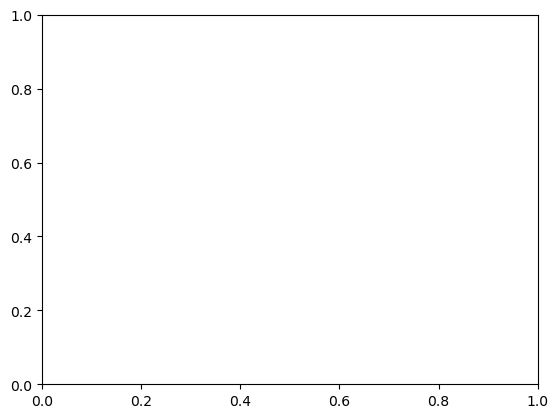

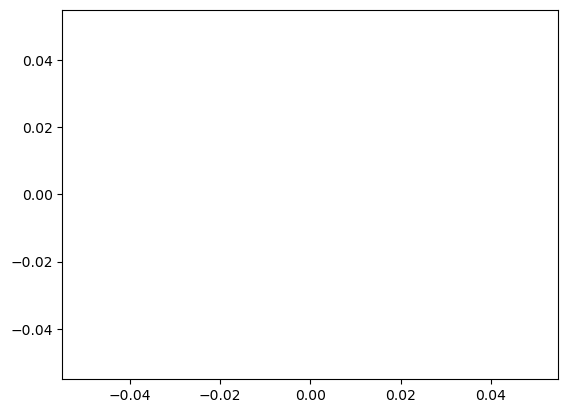

In [375]:
# Expect found signal is ~derivative of actual signal
fig, ax = plt.subplots(1,1)
for i, detector in enumerate(detectors):
    detector.detect_bundles(Npixels=100, relative_phase=np.pi);
    plt.plot(detector.pixels, i/2+detector.powers[-1])
    

plt.show()
plt.plot([detector.difference_signal() for detector in detectors])


In [376]:
import ray_trace
reload(ray_trace)
from ray_trace import sound_speed, trace_bundle, Ray, GaussianBundle, Mirror, \
                      Detector, BiconvexLens, GradientIndexRegion, \
                      lens_parameters, SphericalSource, OpticalSystem

# Function to simulate Sagnac interferometer subject to acoustic source at specified time
def sagnac_sensitivity(slope):
    # Sagnac parameters
    extent = [-0.1, 0.6, -0.2, 0.5] # Overall working space
    arm1 = 0.5 # Horizontal arm length
    arm2 = 0.35 # Vertical arm length
    obs_distance = 0.08 # Distance of detector from beam splitter dark port
    mirror_size = 25e-3 # Mirror diameter

    # 1:1 telescope parameters
    target_focal_length = 0.15 # Single lens focal length
    approximate_thickness = 0.01 # Lens thickness
    lens_index = 1.5 # Lens refractive index (~1.5 for BK7 glass)

    # Optical beam parameters for each arm (CW and CCW), modeled as a bundle of rays
    Nrays = 500 # number of rays per beam
    beam_waist = 3e-3/2 # Gaussian waist used to scale ray powers
    beam_power_ratio = 1 # CCW / CW beam beam powers (CW beam power taken as unity)

    epicenter = [arm1/2, arm2] # Spherical wave center
    grin_step_size = 1e-5 # Runge-Kutta step size for ray tracing in gradient index (GRIN) medium

    
    def index_func(point):
        import numpy as np
        return 1 + np.array([0.0, slope] )@ (point - epicenter)
   
    def grad_index_func(point):
        import numpy as np
        return np.array([0.0, slope])

    grin = GradientIndexRegion(index_func, grin_step_size,
                               [[epicenter[0]-0.002, epicenter[0]+0.01, 200],
                                [epicenter[1]-0.005, epicenter[1]+0.005, 200]],
                                grad_index_func=grad_index_func,
                               )
    
    # Set up mirrors
    BS = Mirror(mirror_size, [0, 0], np.pi/4)
    M1 = Mirror(mirror_size, [arm1, BS.center[1]], np.pi/4)
    M2 = Mirror(mirror_size, [arm1, arm2], -np.pi/4)
    M3 = Mirror(mirror_size, [BS.center[0], arm2], np.pi/4)
    detector = Detector(6*beam_waist, [BS.center[0], -obs_distance], 0)

    # Set up telescope
    lens_radius, lens = lens_parameters(target_focal_length, approximate_thickness, lens_index)
    x = (lens.thickness/2 + lens.focal_length - lens.principal_plane1) # distance from lens center to focus for thick lens
    L1 = BiconvexLens(lens_radius, lens_radius, lens.thickness, lens.index, [arm1/2-x, arm2], 0.0)
    L2 = BiconvexLens(lens_radius, lens_radius, lens.thickness, lens.index, [arm1/2+x, arm2], 0.0)

    # CW and CCW branches
    CW_sys = OpticalSystem(extent=extent, objects=[BS, L1, L2, grin, M1, M2, M3, detector]) # include BS for CW
    CCW_sys = OpticalSystem(extent=extent, objects=[L1, L2, grin, M1, M2, M3, detector]) # exclude BS for CCW
    CW_bundle = GaussianBundle(waist=beam_waist, center=[extent[0], BS.center[1]], direction=[1,0.], number=Nrays, total_power=1)
    CCW_bundle = GaussianBundle(waist=beam_waist, center=[extent[0], BS.center[1]], direction=[1,0.], number=Nrays, total_power=beam_power_ratio)

    # Trace rays
    trace_bundle(CW_sys, CW_bundle, n_jobs=-1)
    trace_bundle(CCW_sys, CCW_bundle, n_jobs=-2)
    detector.set_bundles([CW_bundle, CCW_bundle])
    return CW_sys, detector

1 3
Traced 500 rays in 28.925255060195923 s
Traced 500 rays in 29.9422128200531 s


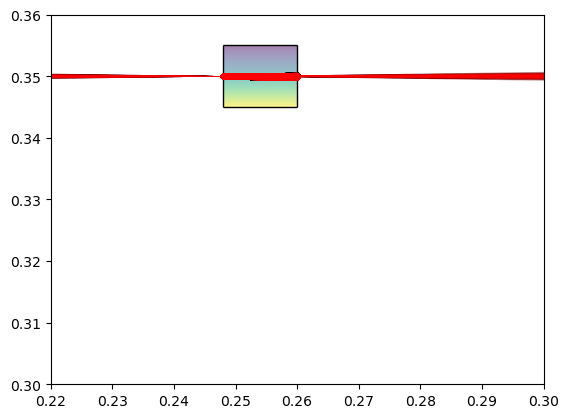

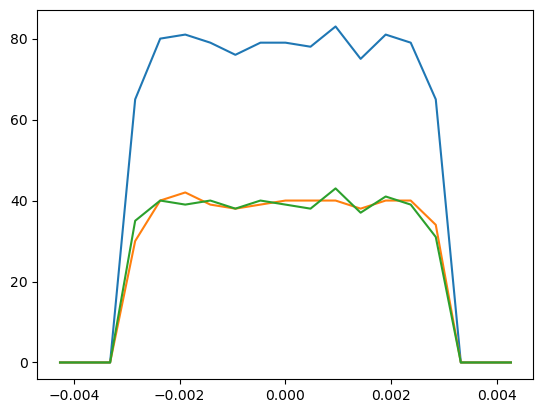

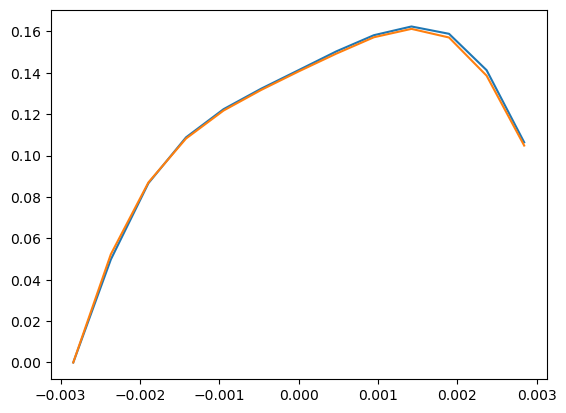

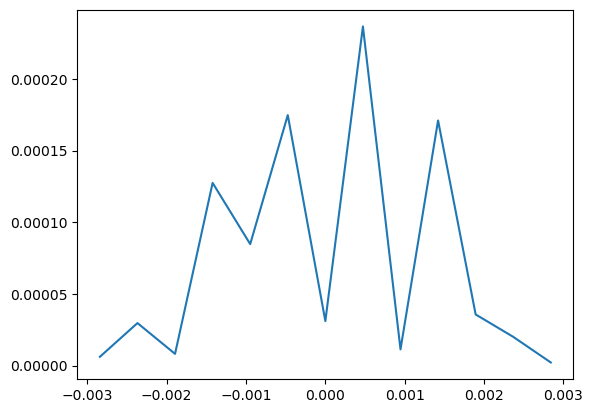

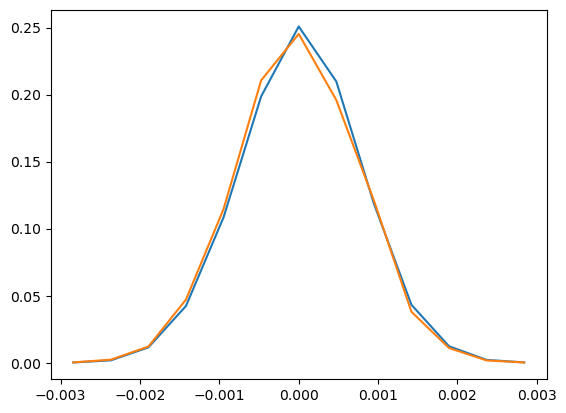

2 3
Traced 500 rays in 35.21249461174011 s
Traced 500 rays in 34.42426586151123 s


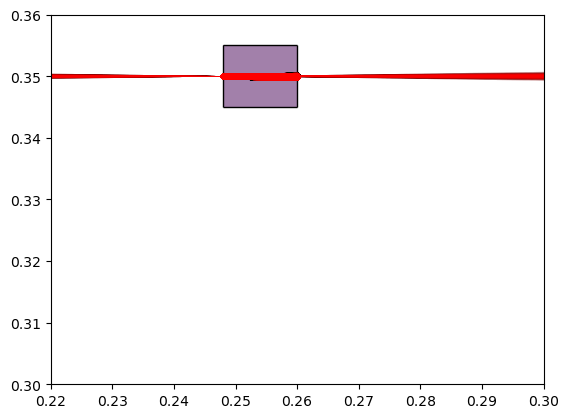

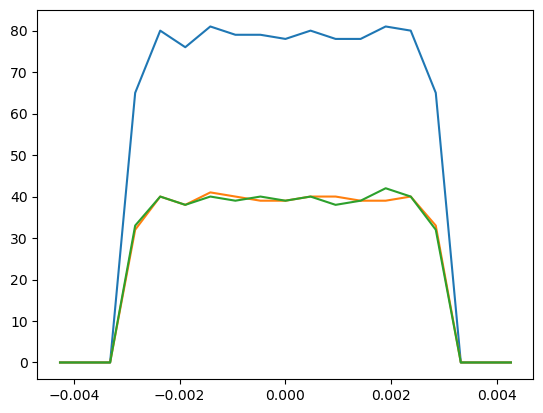

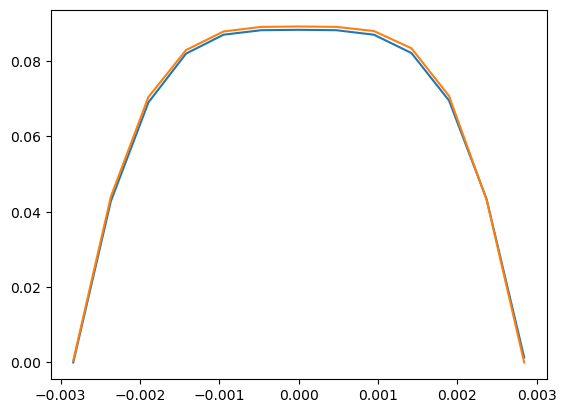

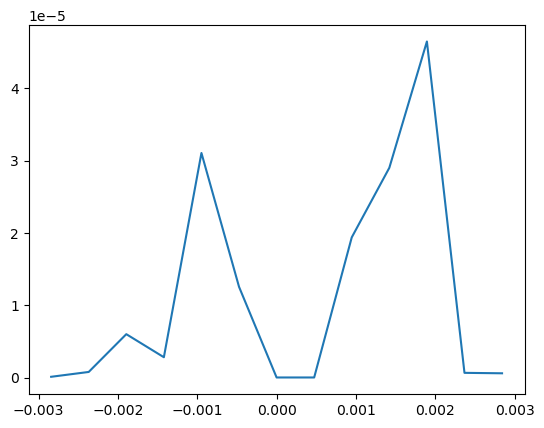

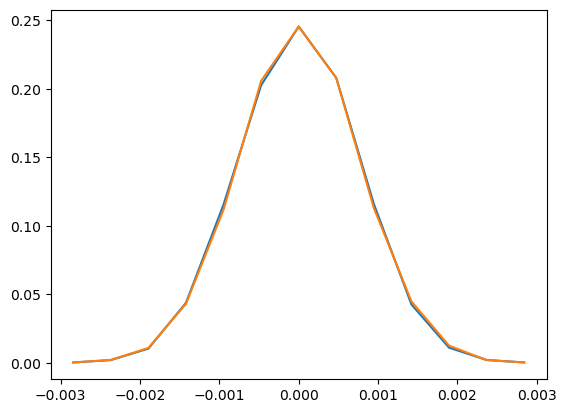

3 3
Traced 500 rays in 35.83194947242737 s
Traced 500 rays in 33.5375919342041 s


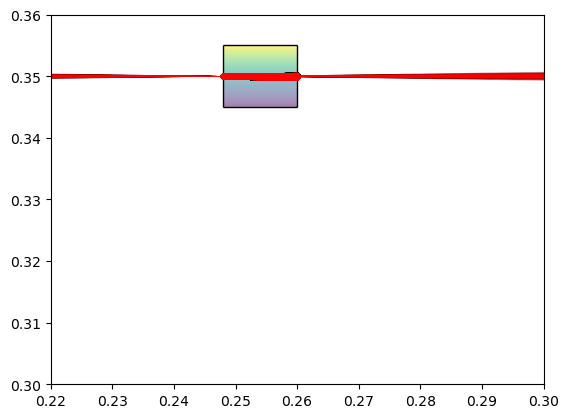

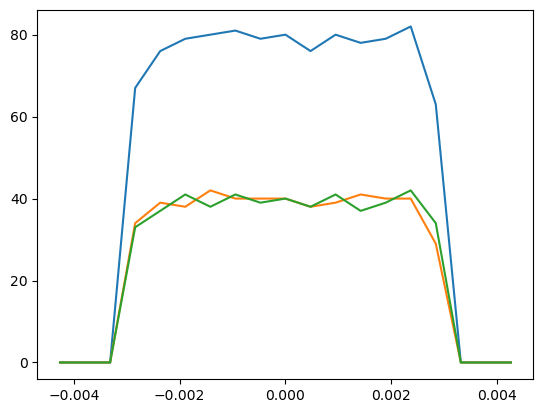

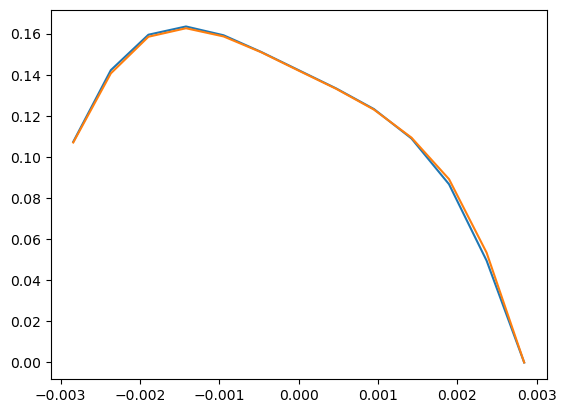

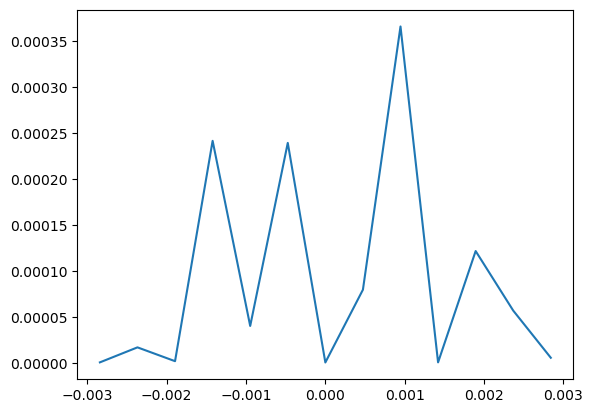

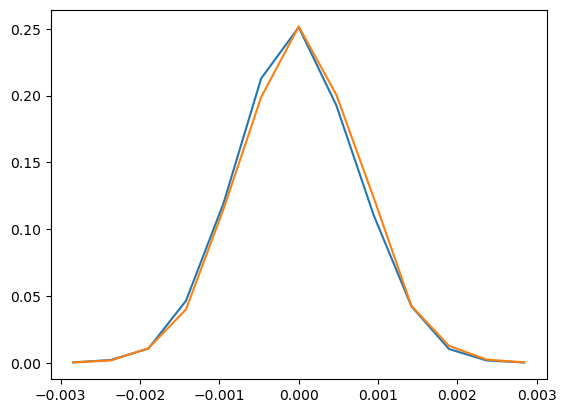

In [377]:
slopes = [-1e-2, 0, 1e-2]
detectors = []
i = 0

for slope in slopes:
    print(i+1, len(slopes))
    i += 1
    
    CW_sys, detector = sagnac_sensitivity(slope)
    detectors.append(detector)
    # Interference between beams
    detector.detect_bundles(Npixels=20, relative_phase=np.pi);
    
    fig, ax = plt.subplots(1,1)
    #ax.set_xlim(CW_sys.extent[:2])
    #ax.set_ylim(CW_sys.extent[2:])
    ax.set_xlim(0.22,0.3)
    ax.set_ylim(0.3,0.36)
    CW_sys.plot(ax)
    for bundle, color in zip(detector.bundles, ("k", "r")):
        bundle.plot(ax, color=color, lw=0.1, marker=".")
    plt.show()
    
    plt.plot(detector.pixels, detector.counts[-1])
    plt.plot(detector.pixels, detector.counts[0])
    plt.plot(detector.pixels, detector.counts[1])
    plt.show()
    
    plt.plot(detector.pixels, detector.phases[0])
    plt.plot(detector.pixels, detector.phases[1])
    plt.show()

    fig, ax = plt.subplots(1,1)
    detector.plot_signal(ax)
    
    
    fig, ax = plt.subplots(1,1)
    detector.plot_signal(ax, bundle_index=0)
    detector.plot_signal(ax, bundle_index=1)

    plt.show()

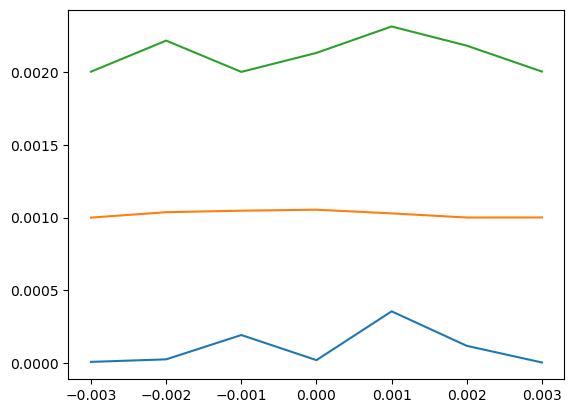

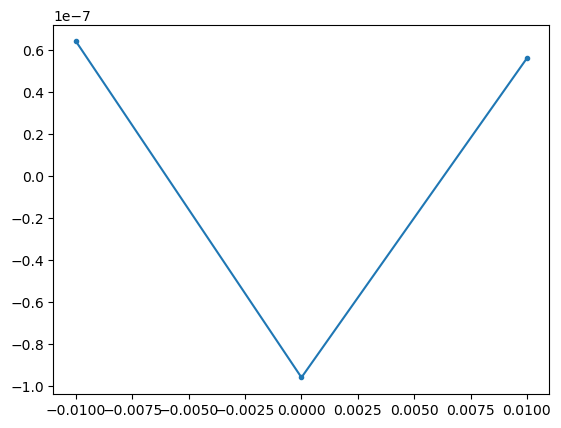

In [382]:
# Expect found signal is ~derivative of actual signal
fig, ax = plt.subplots(1,1)
for i, detector in enumerate(detectors):
    detector.detect_bundles(Npixels=10, relative_phase=np.pi);
    plt.plot(detector.pixels, i/1000+detector.powers[-1])
    

plt.show()
plt.plot(slopes, [detector.difference_signal() for detector in detectors], marker=".")


In [353]:
CW_sys.objects
#[3].grin.grad_index_func([0.5/2, 0.35])

array([ 0.        , -0.38691905])

In [ ]:
def index_func(point):
    import numpy as np
    return 1 + 0.1*np.sin(2*np.pi*point[1]/0.5)


grin = GradientIndexRegion(index_func, 0.01, [[-0.5, 0.5, 100],[ -0.5, 0.5, 100]])

bundle = GaussianBundle(waist=0.1, center=[-1, 0.1], direction=[1,0.], number=100, total_power=1)


sys = OpticalSystem(objects=[grin])
ray = Ray([-1, 0], [1, 0], 1)
trace_bundle(sys, bundle)

fig, ax = plt.subplots(1,1)
sys.plot(ax)
bundle.plot(ax, marker="", c="k")


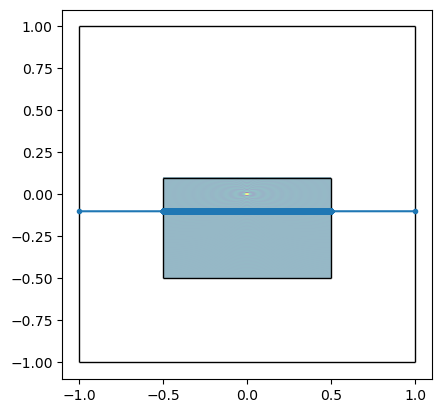

In [217]:
import sys
sys.path.append("./")
from importlib import reload
import ray_trace
reload(ray_trace)
from ray_trace import sound_speed, trace_bundle, Ray, GaussianBundle, Mirror, \
                      Detector, BiconvexLens, GradientIndexRegion, \
                      lens_parameters, SphericalSource, OpticalSystem




# Acoustic source parameters
reference_amplitude = 2.7e-5 # Boundary condition
reference_distance = 10e-2 # Boundary condition
frequency = 40e3 # Acoustic frequency
epicenter = [0,0] # Spherical wave center
def temporal_profile(time, frequency): # Functional form of sound source's temporal profile, converted to traveling spherical wave 
    import numpy as np
    return np.sin(2*np.pi * frequency * time)

def temporal_derivative(time, frequency): # Functional form of temporal profile derivative (optional: will use interpolation if not given)
    import numpy as np
    return 2*np.pi*frequency * np.cos(2*np.pi * frequency * time)

source = SphericalSource(reference_amplitude, reference_distance, epicenter)


time = 1
index_func = source.make_index_func(time, temporal_profile, frequency)
grad_index_func = source.make_grad_index_func(time, temporal_profile, temporal_derivative, frequency)


grin = GradientIndexRegion(index_func, 0.0001, 
                           [[-0.5, 0.5, 100],
                            [ -0.5, 0.1,100]],
                           grad_index_func=grad_index_func
                         )

bundle = GaussianBundle(waist=0.1, center=[-1, -0.1], direction=[1,0.], number=1, total_power=1)


sys = OpticalSystem(objects=[grin])
ray = Ray([-1, -0.1], [1, -0.0], 1)

sys.trace_ray(ray)
#trace_bundle(sys, bundle, n_jobs=1)

fig, ax = plt.subplots(1,1)
sys.plot(ax)
ray.plot(ax, marker=".")


In [ ]:
plt.semilogx(ray.points[:,0], ray.points[:,1], marker=".")

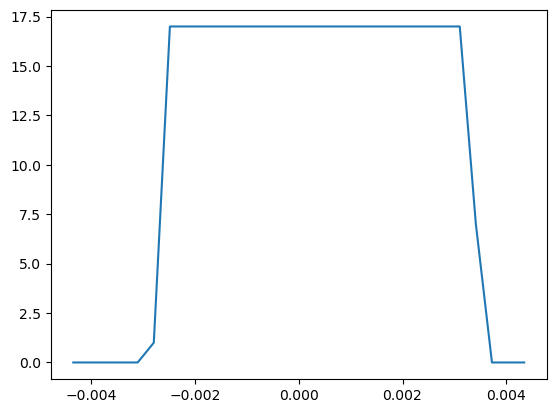

0.9999999999999999

In [116]:
Npixels = 30
lmbda = 1064e-9

final_points = np.array([points[-1] for points in bundle.points])
hit_mask = np.array([detector.point_within(point) for point in final_points])
center_distances = np.array([(point - detector.center)@detector.tangent for point in final_points])
bins = [(point - detector.center)@detector.tangent for point in detector.grid(Npixels)]
count, bins, inds = binstat(center_distances[hit_mask], hit_mask[hit_mask], statistic='count', bins=bins)

set_count = int(np.mean(count))
inds_inds = np.argsort(inds)
i = 0
new_inds_list = []
for k, v in itertools.groupby(inds[inds_inds]):
    size = len(list(v))
    new_inds = np.arange(i, i+min(size, set_count))
    i += size
    new_inds_list.append(new_inds)
new_inds = list(itertools.chain.from_iterable(new_inds_list))
new_inds = inds_inds[new_inds]

A

optical_path_lengths = bundle.optical_path_lengths[hit_mask][new_inds]

opl, bins, _ = binstat(center_distances[hit_mask][new_inds], optical_path_lengths, statistic='mean', bins=bins)
#power, bins, _ = binstat(center_distances[hit_mask][new_inds], bundle.powers[hit_mask][new_inds], statistic='sum', bins=bins)
#power, bins, _ = binstat(center_distances[hit_mask], bundle.powers[hit_mask], statistic='mean', bins=bins)
power = power * bundle.total_power * (np.sum(hit_mask)/len(hit_mask)) / np.nansum(power)

phases = (opl * 2*np.pi/lmbda)
amplitudes = np.sqrt(power) * np.exp(-1j * phases)
pixels = bins[:-1]
pixels += np.diff(bins)[0]/2

plt.plot(pixels, count)
plt.show()
np.nansum(power)